<a href="https://colab.research.google.com/github/simonsavine/phasetype/blob/main/markov_chain_simulation_discrete_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [ ]:
# Helper functions

In [ ]:
def is_square(R):
  shape = np.shape(R)

  if len(shape) != 2:
    return False

  return shape[0] == shape[1]


def is_proba_vector(P):
  if np.any(P < 0):
    return False

  return np.isclose(np.sum(P),1)

In [ ]:
def is_transition_matrix(R):
  shape = np.shape(R)

  if not is_square(R):
    return False

  if shape[0] != shape[1]:
    return False

  n=shape[0]
  for i in range(n):
    if not is_proba_vector(R[:, i]):
      return False

  return True

In [ ]:
def is_diagonalizable(R):
  if not is_square(R):
    return False

  ls, V = np.linalg.eig(R)

  return np.abs(np.linalg.det(V)) > 1e-6

In [ ]:
def make_random_transition_matrix(n, diagonalizable=True):
  R = np.random.random((n, n))

  for i in range(n):
    R[:, i] /= np.sum(R[:, i])

  if diagonalizable:
    return R

  if not is_diagonalizable(R):
    return make_random_transition_matrix(n, True)


In [ ]:
# End of helper functions

In [ ]:
class MarkovChain:

  def __init__(self, R):

    assert is_transition_matrix(R), 'not a transition matrix'
    assert is_diagonalizable(R), 'not a diagonalizable matrix'

    self.n = np.shape(R)[0]
    self.R = R
    self.ls, self.V = np.linalg.eig(R)

    self.invV = np.linalg.inv(self.V)

  def calc_Rm(self, m=1):
    r_power_m = self.V @ np.diag(self.ls ** m) @ self.invV if m > 1 else self.R
    # dump (numerical) imaginary part, eigenvalues of stochastic matrices are always real
    return np.real(r_power_m)

  # Calculate Pi+m knowing Pi
  def calc_probas(self, Pi, m=1):
    return self.calc_Rm(m) @ Pi

  # Calculate Pr(Xi+m | Xi = k)
  def calc_probas_definitestate(self, k, m=1):
    return self.calc_Rm(m) [:, k]

  def sample_path(self, m, X0):
    x = X0
    xs=[X0]

    for _ in range(1, m):
      # next step probas are in the column of R corresponding to current state
      ps = R[:, x]
      x = np.random.choice(self.n, p=ps)
      xs.append(x)

    return np.array(xs)

  def sample_paths(self, m, X0, M):
    paths = []
    for _ in tqdm.tqdm(range(M),f"simulating {M} paths" ):
      paths.append(self.sample_path(m, X0))

    return np.array(paths)



In [ ]:
# test our Markov chain

In [ ]:
n = 5
R = make_random_transition_matrix(n)
R

array([[3.24765109e-01, 2.40390319e-01, 2.66652638e-01, 7.63243287e-02,
        2.80386179e-01],
       [1.87960293e-01, 2.71199768e-01, 8.28634448e-02, 3.22285491e-01,
        2.57848963e-01],
       [2.91547592e-01, 2.26064235e-01, 1.76239858e-01, 1.55059610e-01,
        7.02479844e-02],
       [9.89837735e-02, 2.62060417e-01, 3.26398583e-01, 3.58685220e-01,
        2.36341036e-01],
       [9.67432321e-02, 2.85260378e-04, 1.47845477e-01, 8.76453506e-02,
        1.55175837e-01]])

In [ ]:
sums = np.sum(R, axis=0)
assert np.allclose(sums, 1)

In [ ]:
chain = MarkovChain(R)

In [ ]:
# 1,000 paths over 50 steps
m = 50
M = 1000
paths = chain.sample_paths(m = m, X0 = 0, M = M)

simulating 1000 paths: 100%|██████████| 1000/1000 [00:04<00:00, 248.72it/s]


In [ ]:
first_path = paths[0, :]
assert len(first_path) == m
first_path

array([0, 0, 2, 2, 3, 2, 2, 3, 3, 3, 0, 2, 0, 2, 1, 0, 4, 1, 2, 4, 3, 4,
       4, 3, 1, 2, 3, 4, 1, 0, 0, 4, 3, 3, 3, 0, 2, 0, 3, 3, 1, 1, 2, 3,
       3, 2, 3, 3, 2, 1])

In [ ]:
final_states = paths[:, -1]
assert len(final_states) == M
final_states.shape, final_states[:10]

((1000,), array([1, 1, 1, 0, 3, 0, 3, 3, 3, 1]))

In [ ]:
states, counts = np.unique(final_states, return_counts=True)
freqs = counts / np.sum(counts)

In [ ]:
freqs

array([0.239, 0.235, 0.189, 0.251, 0.086])

In [ ]:
probas = chain.calc_probas_definitestate(0, m - 1)

Text(0.5, 1.0, '1000 sample paths, probabilities at time step i=50')

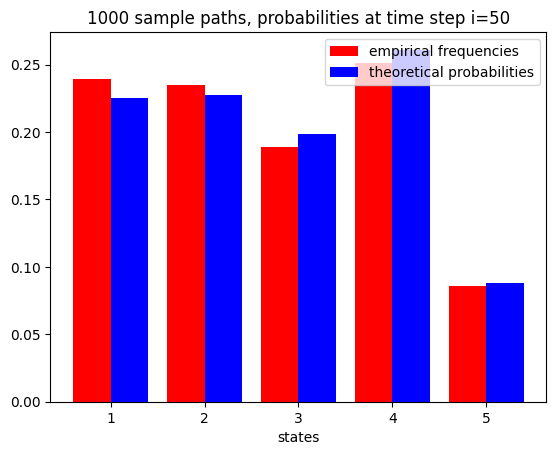

In [ ]:
plt.bar(states + 0.8, freqs, 0.4, color='r', label = 'empirical frequencies')
plt.bar(states + 1.2, probas, 0.4, color='b', label = 'theoretical probabilities')
plt.legend()
plt.xlabel("states")
plt.title(f"{M} sample paths, probabilities at time step i=50")


In [ ]:
# repeat with 10,000 and 100,000 sample paths
# allow around 2-3min
freqs = {}
for M in [1000, 10000, 100000]:
  paths = chain.sample_paths(m = m, X0 = 0, M = M)
  final_states = paths[:, -1]
  states, counts = np.unique(final_states, return_counts=True)
  freqs[M] = counts / np.sum(counts)

simulating 100000 paths: 100%|██████████| 100000/100000 [02:15<00:00, 739.66it/s]


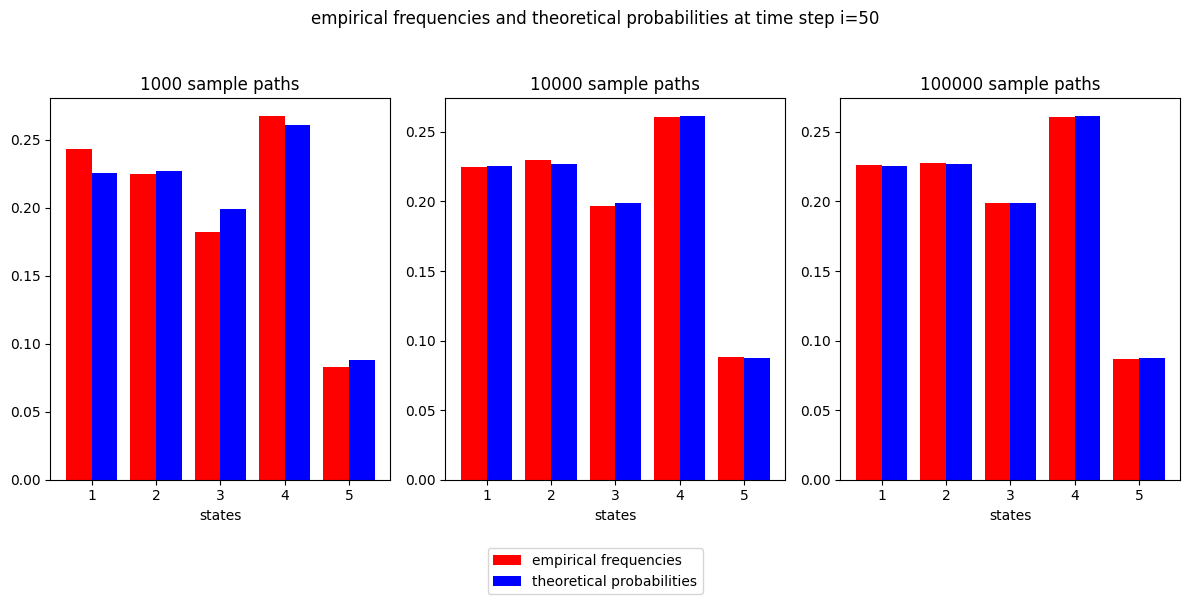

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12,6))
for ax, (M, freq) in zip(axs, freqs.items()):
  ax.bar(states + 0.8, freq, 0.4, color='r', label = 'empirical frequencies')
  ax.bar(states + 1.2, probas, 0.4, color='b', label = 'theoretical probabilities')
  ax.set_xlabel("states")
  ax.set_title(f"{M} sample paths")

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center")
fig.suptitle("empirical frequencies and theoretical probabilities at time step i=50")
plt.tight_layout(rect=[0, 0.1, 1, 0.95])
